# Sieci neuronowe - pierwszy stopień wtajemniczenia

Dzisiaj pod lupę weźmiemy jeden z najpopularniejszych i wszechstronnych modeli uczenia maszynowego - sieci neuronowe. Skupimy się na dwóch zagadnieniach: jak znaleźć optymalną architekturę sieci oraz o arcyważnym problemie regularyzacji. Będziemy pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Import danych MNIST

In [1]:
import numpy as np
import tensorflow as tf
import keras

# Dzisiaj usuniemy przypadkowość z ćwiczenia, żeby mieć pewność, że zobaczymy to, co planuję ;)
seed = 128
rng = np.random.RandomState(seed)

11493376/11490434 [==============================] - 0s 0us/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]

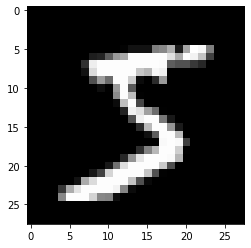

In [2]:
from keras.datasets import mnist
 
# MNIST współpracuje z keras, zbudowany jest z predefiniowanych 60 000 danych treningowych i 10 000 danych testowych
(X_train, y_train), (X_test, y_test) = mnist.load_data()

from matplotlib import pyplot as plt
print(X_train[0])
plt.imshow(X_train[0], cmap='gray')

Dzisiaj korzystamy z głębokich sieci neuronowych, ale one wciąż nie są przystosowane do analizy obrazków (w przeciwieństwie do sieci, których będziemy używać na kolejnych zajęciach). Na wejściu potrzebują więc jednowymiarowy ciąg danych. Musimy też nasze dane znormalizować.

In [3]:
# Reshape'ujemy
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train[0])
print(X_train[0].shape)

# Przygotowujemy inty do dzielenia
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Wyjątkowy sposób normalizacji, bo wiemy, że piksele czarno-białe zawierają się w zakresie od 0 do 255
X_train /= 255
X_test /= 255

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [4]:
from keras.utils import np_utils

# Musimy jeszcze popracować z etykietkami. Mamy wskazanie, który obrazek przedstawia którą liczbę, ale sieć potrzebuje szczególnego sformatowania
print("Oryginalny sposób zapisu: ", y_train[0])
print(y_train.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print("Po zmianie: ", Y_train[0])
print(Y_train.shape)

Oryginalny sposób zapisu:  5
(60000,)
Po zmianie:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(60000, 10)


## Stworzenie pierwszej architektury sieci neuronowej

Pierwsza najważniejsza informacja z dzisiejszych zajęć: **nie ma uniwersalnych i uznanych szczegółowych zasad jak budować optymalną sieć neuronową dla danego problemu**. Głównymi narzędziami programistów są "metoda prób i błędów" oraz stworzona przed doświadczenie intuicja. Wielu matematyków i informatyków głowi się nad bardziej ścisłym sformułowaniu tego zagadnienia, są już pewne poszlaki, dla zainteresowanych polecam [tę publikację](https://arxiv.org/abs/1712.04741).

Także i my jesteśmy skazani na metodę prób i błędów. Naszym pierwszym wyznacznikiem będzie skuteczność samego treningu. Będziemy obserwować jak zmienia się funkcja błędu i dokładność (accuracy). Nie musimy szukać lepszej miary jakości, jako że mamy zbalansowany zestaw danych.

Drugim wyznacznikiem będzie skuteczność modelu na zestawie testowym (lub walidacyjnym, jak zobaczymy na końcu ćwiczenia).

In [5]:
# Importujemy biblioteki do zbudowania sieci
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

epochs = 10
batch_size = 128

model = Sequential()
model.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas

model.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
Total params: 1,149,010
Trainable params: 1,149,010
Non-trainable params: 0
_________________________________________________________________


## Pierwszy trening

Zastosujemy algorytm optymalizacyjny Adam (ze względu na jego dużą szybkość, choć w ogólności ma swoje problemy i warto pamiętać o istnieniu SGD + momentum). Będziemy obserwować dokładność i funkcję błędu modelu zarówno na danych treningowych, jak i testowych.

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_noreg = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/10
469/469 [==============================] - 12s 23ms/step - loss: 0.4008 - accuracy: 0.8780 - val_loss: 0.1236 - val_accuracy: 0.9619
Epoch 2/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0902 - accuracy: 0.9722 - val_loss: 0.1001 - val_accuracy: 0.9702
Epoch 3/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0602 - accuracy: 0.9811 - val_loss: 0.0939 - val_accuracy: 0.9709
Epoch 4/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 0.0872 - val_accuracy: 0.9741
Epoch 5/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.0862 - val_accuracy: 0.9782
Epoch 6/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0290 - accuracy: 0.9909 - val_loss: 0.0726 - val_accuracy: 0.9812
Epoch 7/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0241 - accuracy: 0.9926 - val_loss: 0.0904 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


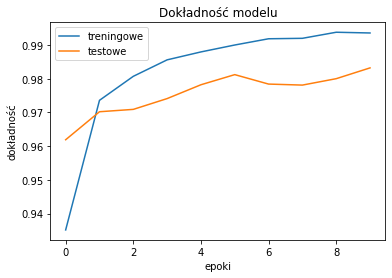

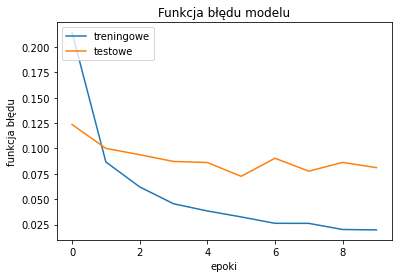

In [7]:
# Sprawdźmy jakie dane o treningu są zapisane dla naszego treningu 'trained_model_5d'
print(trained_model_noreg.history.keys())

model_history = trained_model_noreg
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

Co widzicie?

**Odp: Dane treningowe w pierwszej epoce są gorzej fittowane niż testowe. Następuje szybki wzrost dokładności w kolejnej epoce, który stopniowo się zwiększa aż do 99% poprawnych odpowiedzi. Z kolei dane testowe w pierwszej epoce są nieco lepiej fittowane niż treningowe, jednak w kolejnych epokach nie osiągają aż tak wysokiego poziomu. Świadczy to o przeuczeniu modelu i w związku z tym niemożności zbliżenia się do dokładności osiąganej na danych treningowych.

## Metody regularyzacji

Coś co powinno Wam dawać do myślenia to to, że jest dowód matematyczny na to, że sieć neuronowa z jedną warstwą jest w stanie dowolnie dokładnie aproksymować dowolną funkcję matematyczną. A my stosujemy nie jedną, a kilka warstw! W pierwszym przybliżeniu to dla Was sygnał, że sieci neuronowe są świetne do opisywania dowolnie skomplikowanych problemów, także tych nie istniejących :P mam na myśli, że jak dacie sieci wystarczająco dużo parametrów i czasu do treningu, to będzie w stanie wyciągnąć 100% dokładności na danych treningowych. Gwarantuję Wam jednak, że konsekwencją będzie też kiepska generalizacja, czyli dokładność na danych niewidzianych podczas treningu będzie znacząco mniejsza.

Serce uczenia maszynowego nie leży w fitowaniu modelu do danych. Leży w dobrej generalizacji tego modelu na dane niewidoczne podczas treningu.

Gdy widzimy, że model świetnie działa na danych treningowych, a źle generalizuje (tzw. overfitting), to możemy dokonać zmian:
- w modelu
- w danych

Drugi sposób pokażę Wam za tydzień, dziś się skupimy na pierwszym podejściu. Zawsze można próbować uprościć architekturę, tak aby dokładność modelu na danych treningowych utrzymała się na podobnym poziomie, a wzrosła na testowych. Ponadto, na pomoc przychodzą nam metody regularyzacji, które zmieniają nam nieco model, upraszczają go i zwiększają zdolność generalizacji.

### Wczesne zatrzymywanie (Early Stopping)

To metoda ograniczająca czas treningu - zostaje on przerwany po wystąpieniu n epok z rzędu (n = patience), podczas których funkcja błędu walidacyjna się nie zmienia.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
Total params: 1,149,010
Trainable params: 1,149,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0214 - accuracy: 0.9944 - val_loss

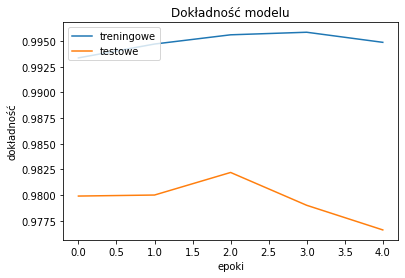

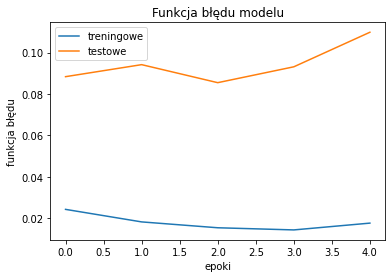

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

model_stop = model

model_stop.summary(line_length=None, positions=None, print_fn=None)

model_stop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_stop = model_stop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), 
                                    callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

model_history = trained_model_stop
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

### Regularyzacja L2 i L1

To dołożenie do funkcji błędu czynników, które rosną wraz z wielkością wag w modelu - karzą model za wagi o dużych wartościach. Bazuje na założeniu, że prostsze modele mają mniejsze wagi.

L1 jest "mocniejsza", czasem aż zeruje wagi, więc jest przydatna w poszukiwaniach optymalnej architektury, gdy szukamy, które neurony wyrzucić, do mniejszej modyfikacji sieci używana jest L2.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5010      
Total params: 1,149,010
Trainable params: 1,149,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 13s 27ms/step - loss: 1.5500 - accuracy: 0.8689 - val_lo

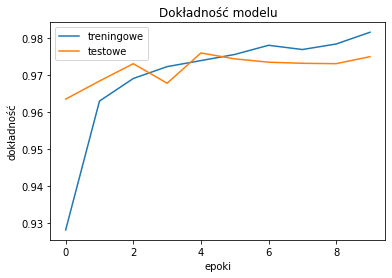

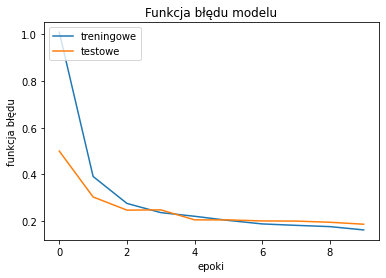

In [9]:
from keras import regularizers

l2_lambda = 0.001

model_l2 = Sequential()
model_l2.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas

model_l2.summary(line_length=None, positions=None, print_fn=None)

model_l2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_l2 = model_l2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

model_history = trained_model_l2
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

### Dropout

Bardzo ciekawe podejście, polegające na losowym zerowaniu % neuronów podczas treningu. To uczy sieć, by nie "polegała" za bardzo na żadnym pojedynczym neuronie.

In [10]:
from tensorflow.keras.layers import Dropout

dropout_rate = 0.25

model_drop = Sequential()
model_drop.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(500, activation='relu'))
model_drop.add(Dropout(dropout_rate))
model_drop.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas

model_drop.summary(line_length=None, positions=None, print_fn=None)

model_drop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_drop = model_drop.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

model_history = trained_model_drop
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'testowe'], loc='upper left')
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)              

KeyboardInterrupt: ignored

# Zadanie na dzisiaj

Metody te można łączyć. W szczególności można myśleć o Early Stopping jako metodzie podpowiadającej jak długo trenować sieć (ile epok), L1 może pomóc przy tworzeniu architektury, L2 lub Dropout stosujemy przy finalnym treningu.

Czujny uczestnik zauważy, że to co tutaj robimy to fitowanie hiperparametrów do danych, tym razem już nie treningowych, ale testowych. A zawsze podkreślaliśmy, że trening (dobieranie parametrów modelu) powinien być oddzielony od ostatecznych danych sprawdzających jakość modelu. Jako że doszedł nam dodatkowy rozbudowany etap - dobieranie hiperparametrów modelu (takich jak liczba epok, częstość Dropoutu, czy siła regularyzacji L1 czy L2), to potrzebujemy dodatkowego zestawu danych. Nazywa się on zestawem "walidacyjnym".

Ostatecznie więc profesjonaliści dzielą cały dostępny zestaw danych na: 

- dane treningowe, do których fitują model, obserwując jednocześnie dokładność na zestawie walidacyjnym
- dane walidacyjne, do których dobiera się hiperparametry
- dane testowe, służące już wyłącznie do sprawdzenia jakości finalnego modelu

Zadanie na dziś to podzielenie obecnego zestawu treningowego na nowy zestaw treningowy i walidacyjny (np. w stosunku 7:3), a następnie wytrenowanie na nim modelu, wybranie dowolnej metody regularyzacji lub ich kombinacji, dobranie optymalnych hiperparametrów i ostatecznie zrobić raport klasyfikacji modelu na danych testowych.

Powodzenia! :)

Połączenie metody L2 z walidacją

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_44 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_45 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_46 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 500)             

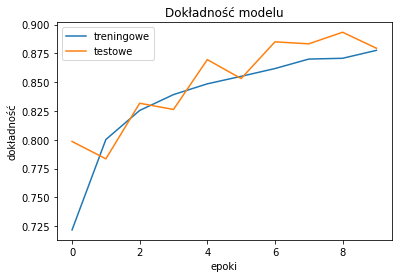

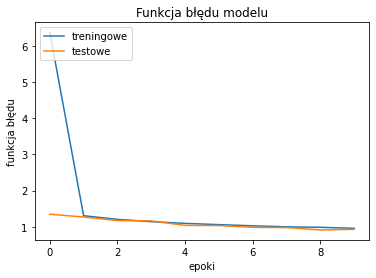

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_48 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_49 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_50 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 500)             

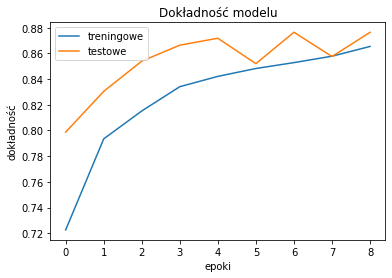

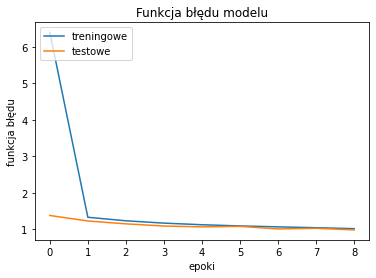

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_52 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_53 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_54 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 500)             

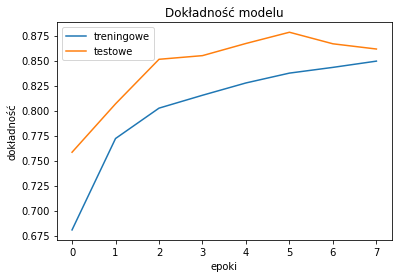

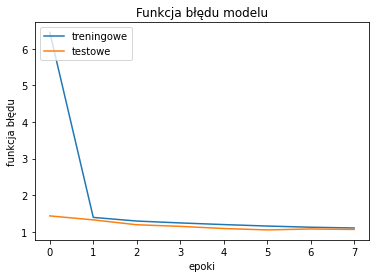

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_56 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_57 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_58 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 500)             

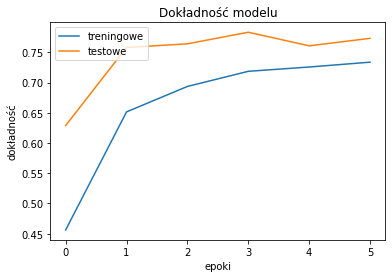

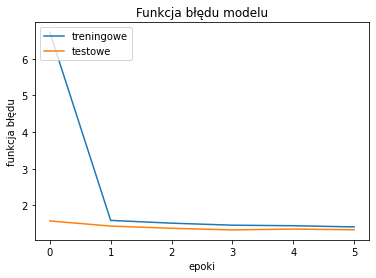

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_60 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_61 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_62 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 500)             

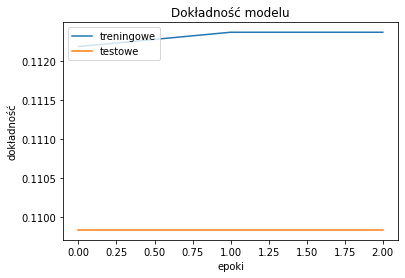

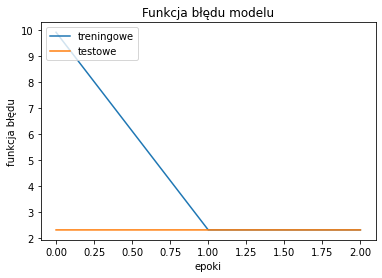

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_64 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_65 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_66 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 500)             

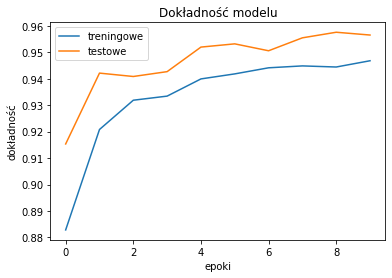

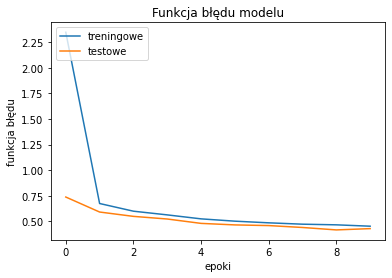

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 500)               392500    
_________________________________________________________________
dropout_68 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_69 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_70 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 500)             

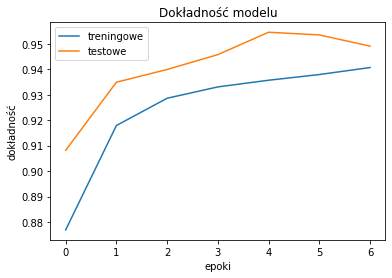

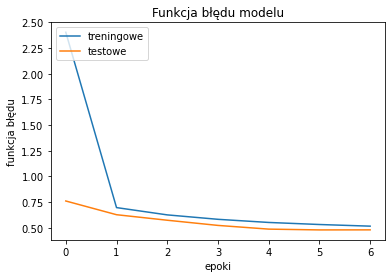

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_72 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_73 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_74 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 500)             

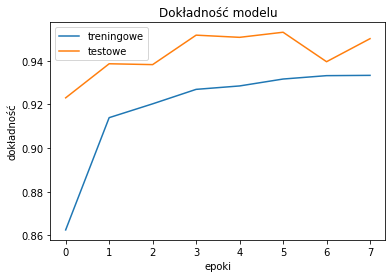

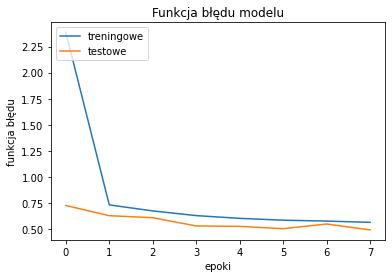

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_76 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_77 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_78 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 500)             

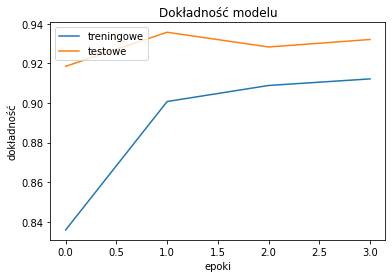

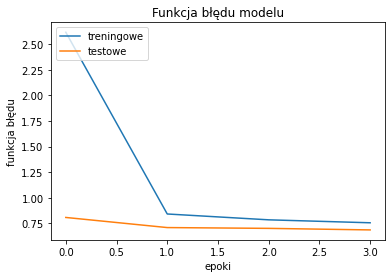

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_80 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_81 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_82 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 500)             

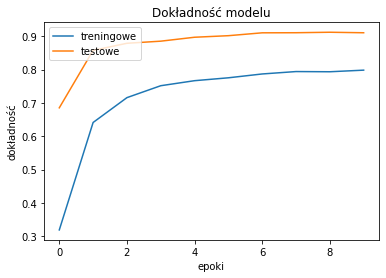

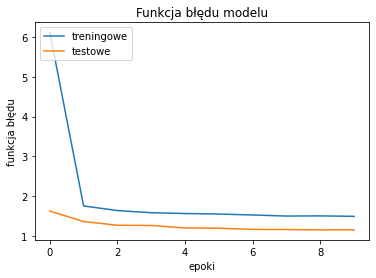

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_84 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_85 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_86 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 500)             

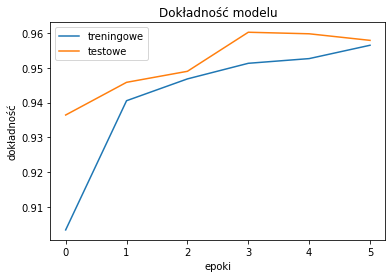

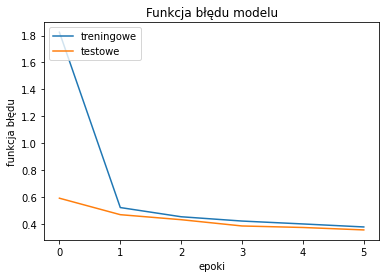

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_88 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_89 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_90 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 500)             

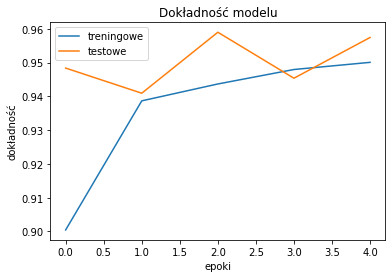

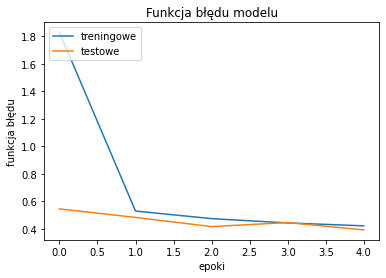

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_92 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_93 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_94 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 500)             

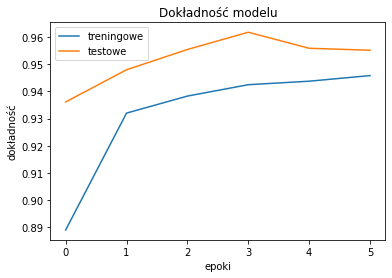

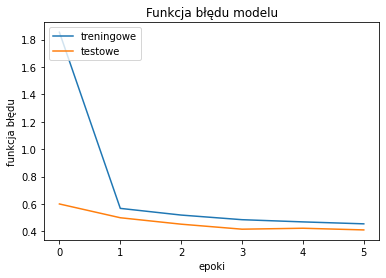

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_96 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_97 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_98 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_133 (Dense)            (None, 500)             

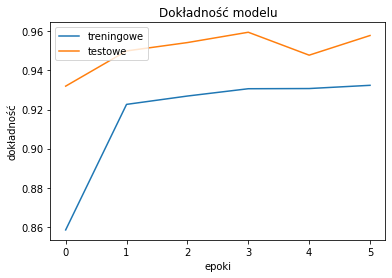

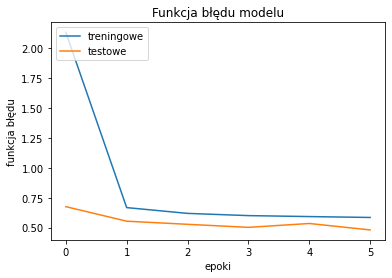

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_100 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_101 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_102 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 500)             

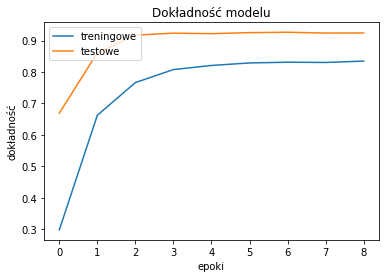

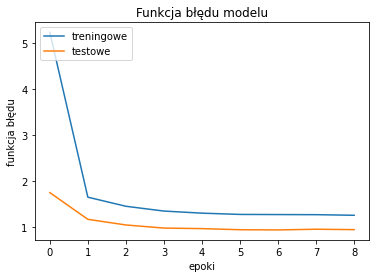

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_104 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_105 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_106 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 500)             

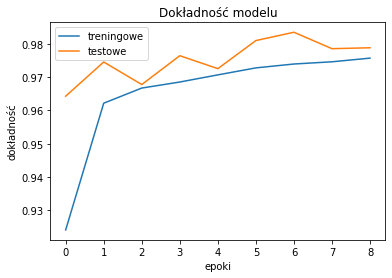

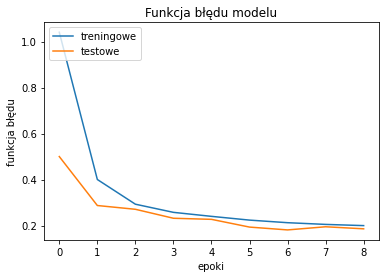

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_108 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_109 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_110 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 500)             

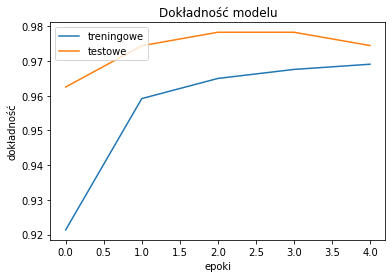

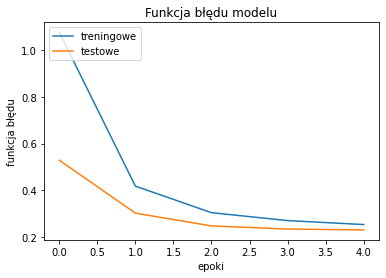

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_112 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_113 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_114 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 500)             

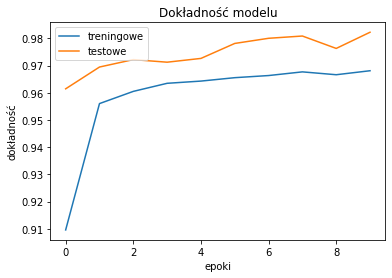

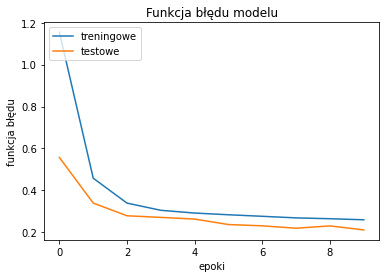

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_116 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_117 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_118 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 500)             

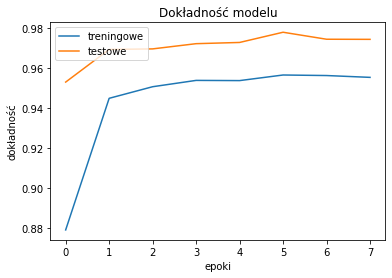

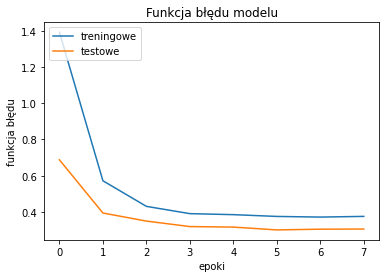

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_120 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_121 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_122 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 500)             

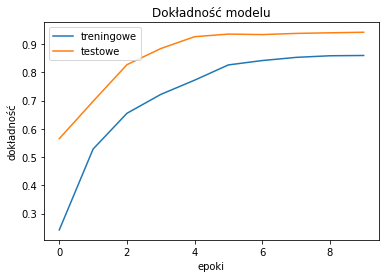

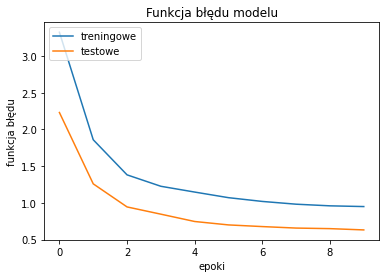

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_124 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_166 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_125 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_126 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_168 (Dense)            (None, 500)             

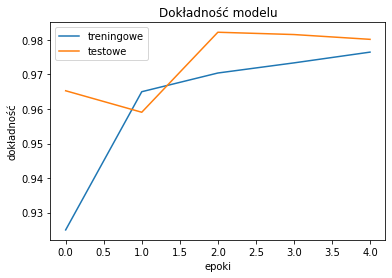

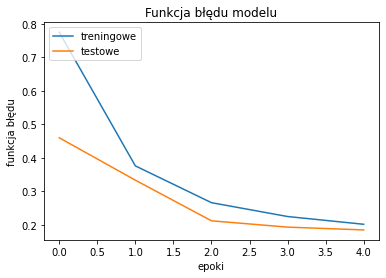

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_128 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_129 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_172 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_130 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 500)             

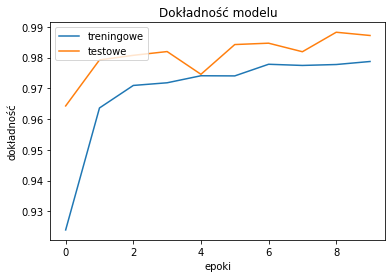

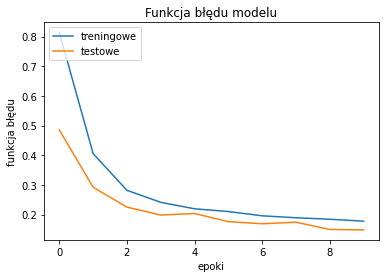

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_132 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_133 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_134 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 500)             

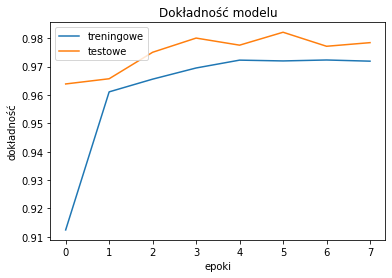

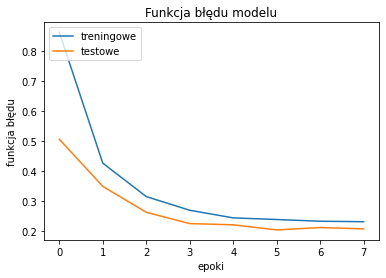

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_136 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_137 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_138 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 500)             

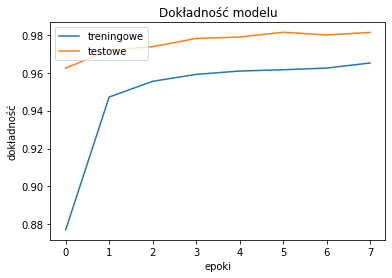

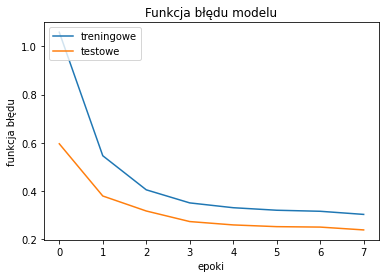

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_140 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_186 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_141 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_142 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 500)             

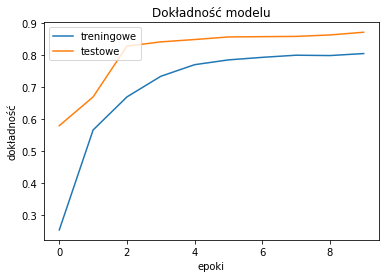

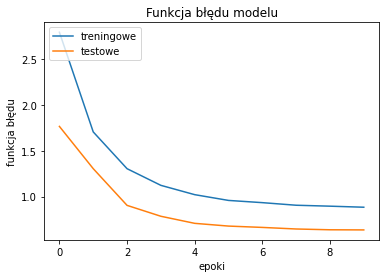

In [21]:
# MNIST współpracuje z keras, zbudowany jest z predefiniowanych 60 000 danych treningowych i 10 000 danych testowych
l2_lambda = 0.001 #do reg. L2

valid_rate = 0.3

#najpierw budujemy sieć
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
import time

def ModelsCheck(l2_lambda, dropout_rate):
  start = time.time()
  model_l2 = Sequential()
  model_l2.add(Input(shape=(784,))) # X_train[0].shape. Poza pierwszą warstwą nie trzeba już definiować "input units"
  model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
  model_l2.add(Dropout(dropout_rate))
  model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
  model_l2.add(Dropout(dropout_rate))
  model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
  model_l2.add(Dropout(dropout_rate))
  model_l2.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
  model_l2.add(Dropout(dropout_rate))
  model_l2.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas
  model_l2.summary(line_length=None, positions=None, print_fn=None)
  model_l2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #dzielimy dane na 0.3 do walidacji
  X_training, X_val, Y_training, Y_val = train_test_split(X_train, Y_train, test_size = 0.3)
  trained_model_l2 = model_l2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), 
                                  callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)] )
  ending = time.time()
  model_history = trained_model_l2
  acc = []
  time_dur = []
  
  # Narysujmy wykresy dla dokładności na danych treningowych i testowych
  print('L2 lambda: ', l2_lambda)
  print('DropoutRate: ', dropout_rate)
  print('Learning time: ', ending - start )

  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('Dokładność modelu')
  plt.ylabel('dokładność')
  plt.xlabel('epoki')
  plt.legend(['treningowe', 'testowe'], loc='upper left')
  plt.show()
  # Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('Funkcja błędu modelu')
  plt.ylabel('funkcja błędu')
  plt.xlabel('epoki')
  plt.legend(['treningowe', 'testowe'], loc='upper left')
  plt.show()
  
  return max(model_history.history['accuracy']), ending - start


#lista testowanych parametrow:
lamb = [0.05, 0.01, 0.005, 0.001, 0.0005]
dropout = [0.05, 0.1, 0.2, 0.4, 0.8]
acc = []
time_dur = []
for l2_lambda in lamb:
  for dropout_rate in dropout:
    accuracy, time_duration = ModelsCheck(l2_lambda, dropout_rate)
    acc.append(accuracy)
    time_dur.append(time_duration)




In [23]:
print(acc)
print(time_dur)

[0.8776000142097473, 0.8653833270072937, 0.8494499921798706, 0.7337833046913147, 0.11236666887998581, 0.9467833042144775, 0.9406499862670898, 0.9333000183105469, 0.9121500253677368, 0.7983333468437195, 0.9564833045005798, 0.950083315372467, 0.9458000063896179, 0.932366669178009, 0.8345166444778442, 0.9757166504859924, 0.9690666794776917, 0.9680833220481873, 0.9564333558082581, 0.859666645526886, 0.9764666557312012, 0.9787166714668274, 0.9723333120346069, 0.9650999903678894, 0.8047000169754028]
[138.5451307296753, 128.9875431060791, 115.14119291305542, 85.81386041641235, 44.23651623725891, 147.54803204536438, 103.15937972068787, 118.77209639549255, 62.396161794662476, 149.24332761764526, 90.74432921409607, 76.83459305763245, 91.2481791973114, 92.12849688529968, 137.77705597877502, 139.97224688529968, 77.85154676437378, 158.66917061805725, 127.24534106254578, 158.09171652793884, 80.94934892654419, 161.71412873268127, 128.52460479736328, 128.19207644462585, 160.8534643650055]


wnioski po obliczeniach dla kilku zmiennych lambda i dropout:
- zbyt duża lambda (powyżej 0.01) prowadzi do całkowitej katastrofy modelu, który daje wyniki dokładności rzędu 10-15% niezależnie od dropoutu
- lambda 0.01 daje zadowalające wyniki ok. 90%, przy czym bardzo interesujące jest to, że sieć ta całkiem dobrze generalizuje dane (dane testowe powyżej danych treningowych)
- duży dropout rate (0.8) daje dobrą generalizację modelu (j.w. : dane testowe lepiej fittowane niż uczące), jednak niestety nie daje szczytowych dokładności (to może oznaczać, że dobrze sobie radzi z przypadkami prostymi, zaś ma za mało danych na przypadki trudniejsze, co skutkuje w dokladności ok. 90%
-krzywa uczenia ma zwykle podobny kształt, tzn. szybki wzrost po pierwszej epoce i stabilny wzrost przypominający krzywą logarytmiczną
-lambda równa 0.005 i niższa przy zastosowaniu stoppingu znacznie przyśpiesza proces uczenia (zwykle kończy się na 5-6 epokach)
- dla użytych danych otrzymujemy bardzo wysokie wartości dokładności (ok. 97-98%) prz niedużej lambdzie (poniżej 0.005) oraz niewielkim dropoucie (0.1-0.4)
-patrząc na dane testowe widzimy dobrą zdolność generalizacji uczenia modelu (sporo krzywych jest powyżej danych treningowych)